# Python and C++ extension

## Non Linear

In [10]:
import sys
sys.path.append('/content/CppToPython')

In [11]:
import numpy as np
import GeDiM4Py as gedim
import time

### Initialize

In [12]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }

gedim.Initialize(config, lib)

## Nonlinear Elliptic Problem POD vs PINNs
"Finta equazione di Burger perchè la facciamo in una sola componente"

The aim of our project is to solve the following parametrized problem on the two-dimensional spatial domain $\bar{\Omega} = [0, 1] \times [0, 1]$: given $\mathbf{\mu}=(\mu_0, \mu_1)\in\mathcal{P}=[0.1,1]\times[0.1,1]$, find $u(\mathbf{\mu})$ such that

$$
\begin{cases}
\displaystyle - \Delta u(\mathbf{\mu}) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) = g(\mathbf{x};\mathbf{\mu}) & \text{in } \Omega\\
u = 0.0 & \text{in } ∂Ω
\end{cases}
$$

where the source term is defined as $g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega$ 

The weak form of the problem becomes, find $u \in V := H^1_0(\Omega)$
$$
\int_{\Omega} \nabla u\cdot\nabla v + \int_{\Omega} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) v - \int_{\Omega} g\, v = 0 \quad \forall v \in V \Leftrightarrow f(u; v) := f_1(u; v) + f_2(u; v) + f_3(u; v) = 0 \quad \forall v \in V
$$

Since f is non linear with respect to $\mu$, we are not able to separate variables.\
Using Newton schema, suitable for non linear functions, we solve for each $k$ iteration the problem
$$
J_f [\partial u]_{|_{u_k}} \partial u = - f(u_k; v) = 0 \quad \forall v \in V
$$
where $J_f [\partial u]_{|_{u_k}}$ is the evaluation of the derivative (Jacobian) of $J_f$ in the point $u_k$ along the unknown direction of $\partial u$.

Notice that the functions $f_1(u; v)$ and $f_3(u; v)$ are linear in $u$ and their Gateux derivatives are given respectively by

$$
    J_{f_1} [\partial u]_{|_{u_k}}=f_1(u; v)=\int_{\Omega} \nabla \partial u \cdot \nabla v \qquad\text{and}\qquad J_{f_3} [\partial u]_{|_{u_k}}=0
$$

On the other hand $f_3(u; v)$ is non-linear in u, and its Gateaux derivative is given by

\begin{align*}
    J_{f_2} [\partial u]_{|_{u_k}}&=\lim_{h\to0}\frac{f_2(u_k+\partial u\, h)-f(u_k)}{h}=\\
    \\
    &=\frac{\mu_0}{\mu_1}\lim_{h\to0}\frac{1}{h}\int_{\Omega} \left(e^{\mu_1\,(u_k+\partial u\, h)}-1\right) v-\int_{\Omega} \left(e^{\mu_1\,u_k}-1\right) v=\\
    \\
    &=\frac{\mu_0}{\mu_1}\lim_{h\to0}\frac{1}{h}\int_{\Omega} e^{\mu_1\,u_k}\left(e^{\mu_1\,\partial u\, h}-1\right) v=\\
    \\
    &=\mu_0\int_\Omega e^{\mu_1\,u_k}\, \partial u\,v 
\end{align*}

which is a reaction term.

After computations, we find the linear system, on each $k$ iteration, fixed $u_k$ find $\partial u$ s.t.

$$
\int_{\Omega} \nabla \partial u \cdot \nabla v + \mu_0\int_\Omega e^{\mu_1\,u_k}\, \partial u\,v  = - \int_{\Omega} \underbrace{\nabla u_k}_{g_1} \cdot \nabla v - \int_{\Omega} \underbrace{\left(e^{\mu_1\,u_k}-1\right)}_{g_2} v + \int_{\Omega} g\, v 
$$
In the left hand side we have the sum of the classic diffusion, reaction and advection terms. In the right hand side we have the function $f(u; v)$ evaluated in $u_k$.

## 1. Solve the problem by means of POD-Galerkin method over a Finite Element full order model
# 1.1 **Test**

 In order to implement an error study of the code we will implement, firstly we solve the Nonlinear Elliptic problem by means of POD-Galerkin method over a Finite Element full order model by choosing the exact solution $u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1-x_0)(1-x_1)$ and computing the respective right hand side define as

 $$
 g_{ex}(\mathbf{x};\mathbf{\mu}) = -\Delta u_{ex}(\mathbf{x};\mathbf{\mu})+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})}-1\right) = 32 (x_0(1-x_0)+x_1(1-x_1))+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
 $$
 
 Then we will apply our code to the problem introduced above.

In [4]:
#the numPoints are the quadrature points in which we evaluate the basis function

########## Coefficient of STIFFNESS MATRIX ##########
def Diffusion(numPoints, points):
	values_d = np.ones(numPoints, order='F')
	return values_d.ctypes.data
#####################################################

########## Functions for REACTION MATRIX ##########
# Coefficient
def Reaction(numPoints, points):
	values_r = mu[0] * np.ones(numPoints, order='F')
	return values_r.ctypes.data

# Coefficient depends on u_k
def Reaction_non_linear(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double) #evaluation of u in quadrature points of our cell
	values_nl = np.exp(mu[1] * vecu)
	return values_nl.ctypes.data
#####################################################

########## Functions for RIGHT HAND SIDE ##########
# Classical right hand side g_ex computed in order to have u(x0,x1)=16*x0*x1*(1-x0)*(1-x1) as the exact solution of the nonlinear elliptic problem
def RHS_g_ex(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_gex = 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	 +  mu[0] / mu[1] * (np.exp(mu[1] * 16 * matPoints[0,:] * matPoints[1,:] * (1.0 - matPoints[0,:]) * (1.0 - matPoints[1,:]))-1)
	return values_gex.ctypes.data

# # Right hand side g given from the problem
# def RHS_g(numPoints, points):
# 	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
# 	values_g = 100.0 * np.sin(2 * np.pi * matPoints[0,:]) * np.cos(2 * np.pi * matPoints[1,:])
# 	return values_g.ctypes.data

# Non linear term evaluated in u_k
def RHS_non_linear_g2(numPoints, points, u, u_x, u_y):
	vecu = gedim.make_nd_array(u, numPoints, np.double) #evaluation of u in quadrature points of our cell
	values_nl = np.exp(mu[1] * vecu)-1
	return values_nl.ctypes.data

# Diffusion term evaluated in u_k
def RHS_non_linear_g1(numPoints, points, u, u_x, u_y): #matrix that contain the gradient of our solution
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F') # we have always the geometric dimension in the rows, and number of points in the columns
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data

#####################################################

################## EXACT SOLUTION ###################
# Evaluation in quadrature points
def Test_exactSolution(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_ex = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]))
	return values_ex.ctypes.data

# Derivatives in each direction
def Test_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values_ex_d = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values_ex_d = np.zeros(numPoints, order='F')

	return values_ex_d.ctypes.data
#####################################################


def Ones(numPoints, points):
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data

def OnesDerivative(numPoints, points):
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data

def Zeros(numPoints, points): 
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data

def ZerosDerivative(direction, numPoints, points):  #gradient null in each direction
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data

### Define Simulation Parameters

Set geometry parameters

In [62]:
meshSize = 0.01 #We choose a meshsize = maximum area required in our domain discretization
order = 1 #Order of finite element

#all the boundary condition are homogenous dirichlet boundary condition so we use just one marker for the border equal to 1
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
# BoundaryConditionsType=2 means Dirichlet conditions
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

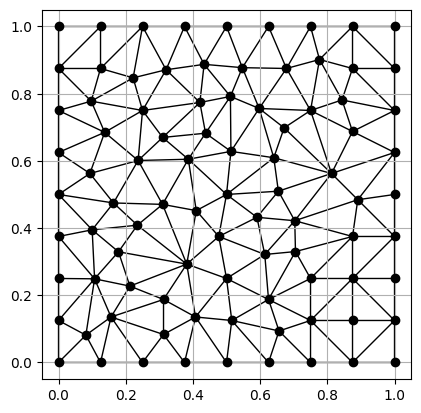

In [63]:
gedim.PlotMesh(mesh)

## **High fidelity solution**

In [58]:
# mu_0 = 0.8
# mu_1 = 0.4
mu = [0.8, 0.4]

tol = 1. - 1e-7
N_max = 10
num_iteration = 1

In [49]:
error_L2 = []
error_H1 = []
norm_L2 = []
norm_H1 = []

In [50]:
def compute_FOM(mu, lib, problemData, compute_time=False, exact_solution=False):
    
    # initialization of newton method
    print(f"Params: [{mu[0]}, {mu[1]}]")
    # Initialization of Newton parameters
    residual_norm = 1.0; # variable in which we store the residual L2 norm
    solution_norm = 1.0; # variable in which we store the solution L2 norm. They are needed in order to implement a Newton step
    newton_tol = 1.0e-6 # tolerance we want to achieve with the solution approximation. It cannot be lower than the machine precision (epsilon di macchina)
    max_iterations = 20 # 7 # if the mesh is not too fine it is not necessary a too high number of iteration
    num_iteration = 1 

    if compute_time:
        # time variables
        time_FOM = list()
        time_assembling_FOM = list()

    # set initial solution
    u_k = np.zeros(problemData['NumberDOFs'], order='F') 
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')

    # Stiffness matrix
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion, problemData, lib)

    if exact_solution:
        forcingTerm_g_ex = gedim.AssembleForcingTerm(RHS_g_ex, problemData, lib)
    else:
        forcingTerm_g = gedim.AssembleForcingTerm(RHS_g, problemData, lib)

    print("HIGH FIDELITY SOLUTION")
    
    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 

        if compute_time:
            start_assembling = time.time()
    
        # Reaction matrix
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction, Reaction_non_linear, u_k, u_strong, problemData, lib)
    
        # reaction = mu_0 * reaction1

        # Forcing term given by the problem
        #forcingTerm_g_ex = gedim.AssembleForcingTerm(RHS_g_ex, problemData, lib)

        # Diffusion term evaluated in u_k
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, RHS_non_linear_g1, u_k, u_strong, problemData, lib)
        
        # Nonlinear term evaluated in u_k
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, RHS_non_linear_g2, u_k, u_strong, problemData, lib)

        if compute_time:
            time_assembling_FOM.append(time.time() - start_assembling)
            # start full solution computation timer
            start = time.time()
            
        # COMPUTE FULL SOLUTION
        if exact_solution: 
            du = gedim.LUSolver(stiffness + reaction, \
                    forcingTerm_g_ex - forcingTerm_v - forcingTerm_der_v, \
                    lib)
        else:
            du = gedim.LUSolver(stiffness + reaction, \
                    forcingTerm_g - forcingTerm_v - forcingTerm_der_v, \
                    lib)
    
        # Newton step: we add to the old solution the increment found with the Newton method
        u_k = u_k + du

        if compute_time:
            time_FOM.append(time.time() - start)

        #Error computation: con il galerkin classico possiamo calcolare l'errore con le funzioni ComputeError, ma se il metodo non è quello classico, non è detto esistano le rispettive funzioni
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib) # we aim it is zero, so we pass to it the zero function
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib) #Similarly t the previous, we pass the function with derivative null along each direction

        if exact_solution:
            u_errorL2 = gedim.ComputeErrorL2(Test_exactSolution, u_k, u_strong, lib)
            u_errorH1 = gedim.ComputeErrorH1(Test_exactDerivativeSolution, u_k, u_strong, lib)
        
        solution_norm = u_normL2;
        residual_norm = du_normL2;

        if exact_solution:
            print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(u_errorL2 / u_normL2), '{:.16e}'.format(u_errorH1 / u_normH1), '{:.16e}'.format(residual_norm / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations)) 
        else:
            print("dofs", "h", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residual_norm / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations)) 
        
        num_iteration = num_iteration + 1

    if compute_time:
        error_L2.append(u_errorL2/solution_norm)
        error_H1.append(u_errorH1/u_normH1)
        # norm_L2.append(solution_norm)
        # norm_H1.append(u_normH1)
        return u_k, u_strong, solution_norm, u_normH1, residual_norm, time_FOM, time_assembling_FOM
    else:
        return u_k, u_strong,solution_norm, u_normH1, residual_norm
    

In [59]:
#[u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm] = compute_FOM(mu, lib, problemData, compute_time=False, exact_solution=True)
[u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=True)
print(f'Computation of FOM time:')
print(sum(time_FOM)+sum(time_assembling_FOM))

Params: [0.8, 0.4]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
7590 2.2216461607488681e-02 6.2163888924895412e-03 1.7366608881176367e-02 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
7590 2.2216461607488681e-02 2.1818831079417945e-02 2.7060362484904340e-02 1.5716117976757489e-02 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
7590 2.2216461607488681e-02 2.2218081219463736e-02 2.7378893738499319e-02 4.0816430889009122e-04 3 20
dofs h errorL2 errorH1 residual iteration max_iteration
7590 2.2216461607488681e-02 2.2228555558605020e-02 2.7387277636441523e-02 1.0713458989513613e-05 4 20
dofs h errorL2 errorH1 residual iteration max_iteration
7590 2.2216461607488681e-02 2.2228830658315143e-02 2.7387497849262383e-02 2.8138932753397074e-07 5 20
Computation of FOM time:
13.692179918289185


In [61]:
print(error_L2)
print(error_H1)

[0.018960593778197095, 0.02026033686387679, 0.022228830658315143]
[0.18043794754357945, 0.05496950166414194, 0.027387497849262383]


## **POD**

Let us define the training set for the POD

In [10]:
### define the training set

snapshot_num = 300
mu1_range = [0.1, 1.]
mu2_range = [0.1, 1.]

# set random seed for a reproducible work
np.random.seed(1)

P = np.array([mu1_range, mu2_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

### Snapshot matrix

We can now proceed with the snapshot matrix creation. However, we need to be careful: the problem is not affine in the parameters and we need to assemble the Reaction matrix and the nonlinear forcing term for each parametric instance.

In [11]:
### Build snapshot matrix
snapshot_matrix = []

for mu in training_set:
    [u_k, _, _, _, _] = compute_FOM(mu, lib, problemData, compute_time=False, exact_solution=True)
    snapshot_matrix.append(np.copy(u_k))

snapshot_matrix = np.array(snapshot_matrix)

Params: [0.47531980423231657, 0.7482920440979423]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 2.8004695132782281e-02 1.8180795319190646e-01 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 5.0640697230882215e-02 1.8686246913212387e-01 2.5440282986904452e-02 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 5.0087792646402118e-02 1.8670982697338726e-01 5.6734678969723256e-04 3 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 5.0100193980061873e-02 1.8671323500545856e-01 1.2747535063906134e-05 4 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 5.0099915337031654e-02 1.8671315842270109e-01 2.8642996149088516e-07 5 20
Params: [0.1001029373356104, 0.3720993153686558]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.06478761001324

In [12]:
print(f'Snapshot matrix dimension (M x N_sigma): {snapshot_matrix.shape}')

Snapshot matrix dimension (M x N_sigma): (300, 57)


### Covariance matrix 
Let us build and analyze the covariance matrix, in order to keep just the most informative columns.

In [13]:
# Inner_product is necessary sicne we are dealing with the energy norm and not L2 norm. 
# As a consequence, the obtained basis won't be the best possible but an approximation of them. (Theorem hypothesis of best approximation is satisfied in L2)
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion, problemData, lib)
inner_product = stiffness

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) ## metti inner product

# VM, L, VMt = np.linalg.svd((C))

# compute eigenvalues and eigenvectors
L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []


#### check

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N)
print(relative_retained_energy)

The reduced dimension is 2
[0.99999379 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.    

### Basis matrix
And now let us build the basis functions and $\mathbb B$.

In [14]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  basis = np.transpose(snapshot_matrix) @ eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis)
  basis /= norm
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))
print(f'Basis functions dimension: {basis_functions.shape}')

Basis functions dimension: (57, 2)


### Standard ROMs
If we want to perform standard ROMs we still need to implement the Newton algorithm and assemble the system.

### New parameters

In [15]:
mu = [0.8, 0.4]

In [16]:
def compute_ROM(mu, lib, problemData, compute_time=False, exact_solution=False):

    # initialization of newton method
    print(f"Params: [{mu[0]}, {mu[1]}]")
    # Initialization of Newton parameters
    residual_norm_proj = 1.0; # variable in which we store the residual L2 norm
    solution_norm_proj = 1.0; # variable in which we store the solution L2 norm. They are needed in order to implement a Newton step
    newton_tol = 1.0e-6 # tolerance we want to achieve with the solution approximation. It cannot be lower than the machine precision (epsilon di macchina)
    max_iterations = 20 # 7 # if the mesh is not too fine it is not necessary a too high number of iteration
    num_iteration = 1 

    if compute_time:
        # time variables
        time_ROM = list()
        time_assembling_ROM = list()

    # set initial solution 
    u_k_proj = np.zeros(problemData['NumberDOFs'], order='F')
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    reduced_u_k = np.zeros(N, order='F')

    # Stiffness matrix
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion, problemData, lib)
    print("REDUCED SOLUTION")

    # Forcing term given by the problem
    if exact_solution:
        forcingTerm_g_ex = gedim.AssembleForcingTerm(RHS_g_ex, problemData, lib)
    else:
        forcingTerm_g = gedim.AssembleForcingTerm(RHS_g, problemData, lib)  
    
    while num_iteration < max_iterations and residual_norm_proj > newton_tol * solution_norm_proj: 

        ##################### REDUCED #########################
        # Stiffness matrix
        # [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion, problemData, lib) 
        # perchè è uguale ad ogni iterazione
        if compute_time:
            start_assembling = time.time()
        
        # Reaction matrix
        [reaction1, reactionStrong1] = gedim.AssembleNonLinearReactionMatrix(Reaction, Reaction_non_linear, u_k_proj, u_strong, problemData, lib)
    
        reaction = mu[0] * reaction1
    
        # Forcing term given by the problem
        # forcingTerm_g_ex = gedim.AssembleForcingTerm(RHS_g_ex, problemData, lib)

        # Diffusion term evaluated in u_k
        forcingTerm_der_v = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative, RHS_non_linear_g1, u_k_proj, u_strong, problemData, lib)
        
        # Nonlinear term evaluated in u_k
        forcingTerm_v = gedim.AssembleNonLinearForcingTerm(Ones, RHS_non_linear_g2, u_k_proj, u_strong, problemData, lib)
        
        
        reduced_stiff = np.transpose(basis_functions) @ stiffness @ basis_functions
        # print(reduced_stiff.shape)
        reduced_reac = np.transpose(basis_functions) @ reaction @ basis_functions

        if exact_solution:
            reduced_fT_gex =  np.transpose(basis_functions) @ forcingTerm_g_ex
        else:
            reduced_fT_g =  np.transpose(basis_functions) @ forcingTerm_g
            
        reduced_fT_der_v =  np.transpose(basis_functions) @ forcingTerm_der_v
        reduced_fT_v =  np.transpose(basis_functions) @ forcingTerm_v

        if compute_time:
            time_assembling_ROM.append(time.time() - start_assembling)
            # start timer for reduced solution computation
            start = time.time()

        # COMPUTE REDUCED
        if exact_solution:
            reduced_du = gedim.LUSolver(reduced_stiff + reduced_reac, \
                    reduced_fT_gex - reduced_fT_der_v - reduced_fT_v, \
                    lib)
        else:
            reduced_du = gedim.LUSolver(reduced_stiff + reduced_reac, \
                reduced_fT_g - reduced_fT_der_v - reduced_fT_v, \
                lib)
        
        # Newton step: we add to the old solution the increment found with the Newton method
        reduced_u_k = reduced_u_k + reduced_du
        
        #Projection of reduced soution u_k
        u_k_proj = basis_functions @ reduced_u_k 

        if compute_time:
            time_ROM.append(time.time() - start)
        
        du_proj = basis_functions @ reduced_du


        # time_ROM.append(time.time() - start)

        #Error computation: con il galerkin classico possiamo calcolare l'errore con le funzioni ComputeError, ma se il metodo non è quello classico, non è detto esistano le rispettive funzioni
        du_normL2 = gedim.ComputeErrorL2(Zeros, du_proj, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k_proj, u_strong, lib) # we aim it is zero, so we pass to it the zero function
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k_proj, u_strong, lib) #Similarly t the previous, we pass the function with derivative null along each direction

        if exact_solution:
            u_errorL2 = gedim.ComputeErrorL2(Test_exactSolution, u_k_proj, u_strong, lib)
            u_errorH1 = gedim.ComputeErrorH1(Test_exactDerivativeSolution, u_k_proj, u_strong, lib)
        
        solution_norm_proj = u_normL2;
        residual_norm_proj = du_normL2;

        if exact_solution:
            print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(u_errorL2 / u_normL2), '{:.16e}'.format(u_errorH1 / u_normH1), '{:.16e}'.format(residual_norm_proj / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))
        else:
            print("dofs", "h", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residual_norm_proj / u_normL2), '{:d}'.format(num_iteration), '{:d}'.format(max_iterations))

        
        num_iteration = num_iteration + 1

    if compute_time:
        return u_k_proj, u_strong, solution_norm_proj, residual_norm_proj, time_ROM, time_assembling_ROM
    else:
        return u_k_proj, u_strong, solution_norm_proj, residual_norm_proj
    

In [17]:
#[u_k, u_strong, sol_norm, res_norm] = compute_ROM(mu, lib, problemData, exact_solution=True)
[u_k, u_strong, sol_norm, res_norm, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=True)
print(f'Computation of ROM time:')
print(sum(time_ROM)+sum(time_assembling_ROM))

Params: [0.8, 0.4]
REDUCED SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 2.3296326375829492e-02 1.8106140671768908e-01 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 1.9003670944963563e-02 1.8044437822268400e-01 8.1445490071933753e-03 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 1.8961011561057711e-02 1.8043804558294024e-01 1.2413366700538597e-04 3 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 1.8960367417454285e-02 1.8043794951268935e-01 1.9066663819924840e-06 4 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 1.8960357533749375e-02 1.8043794803789395e-01 2.9299649972128803e-08 5 20
Computation of ROM time:
0.1559154987335205


In [18]:
# basis_functions.shape

### Plot Solution

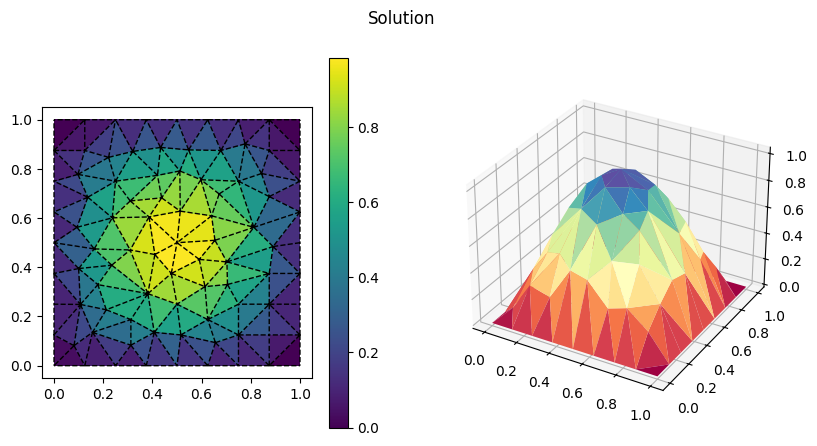

In [19]:
#Visualizzazione della soluzione e calcolo dell'errore FONDAMENTALI NEL PROGETTO !!!
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)

#PLotSolution implements in Pyton the two plot of 2D and 3D plots of the solution. IT's better to export the solution in order to visulize the solution in other applications, as ParaView
#ExportSolution give us a file .inp which is the file format of the UCD structur file. It's limitated to specific type of geometrical elemntsù: tringle hexahedron, thetraedron, pyramidon, line, points.
# Filter "Warp by scalar" in ParaView let choos one of the scalar associated to the solution... to 3D visualization
gedim.ExportSolution(Test_exactSolution, u_k, u_strong, lib)

#Nella costruzione delle funzioni non ci interessava sapere chi fossero i nodi di quadratura per la costruzione delle matrici. In questo caso invece, dovendo valutare l'errore in tutte
#le celle dobbiamo conoscere i nodi di quadratura in tutto il dominio e li salviamo nella matrice globale quadraturePoints
#Inoltre per ogni nodo di quadratura dobbiamo conoscere il peso per cui dobbiamo moltiplicare, altrimenti l'approssimazione dell'integrale non è corretta. 
#La sommma dei pesi è 1 poichè approssimo l'integrale della funzione unitaria che fornisce la misura del nostro dominio
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)

#If the order of FE is 2 the PlotSoution does not use the info on the middle points of the FE but just that on the vertices
#In order to taking account also of the dofs that are not equal to the vertices we use ExtractSolutionOnPoints.
#We have a collection of points and in each point we have a value of the solution: we have the galerkin numerical solution evaluated in each qadrature formula. 
#We don't have the solution on the cells.
#In order to have the solution on cells we have to add a filter to the numeric solution that is associated to each point of the mesh, not to the cell. We need to change cell
#array to point array: using cellDataPointData.
#Then, we have to generate a mesh: we use the Delauneay 2D from the filter on the solution on points. We obtain a mesh conformed to our points.
#The borders are missing because the quadrature formula is implemented INSIDE the cells. We add the warpByScalar filter and we see the expected better approximation of the exact solution
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) 


#If we have a network, notice that sol is an array with shape 864, and for each point we have the evaluation of the solution on each point. In Galerkin it is correct, but not in NN
#In the latter case we have to evaluate the network in quadrature points adding the line 
#nn(QuadraturePoints)
#before the export.

Let us comment a bit on the error analysis and the _speed up_.

In [20]:
abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(20, P.shape[0]))
# speed_up = []
# speed_up_assembling = []
tot_speed_up = []

for mu in testing_set:
    #[u_k, sol_norm_L2, sol_norm_H1, res_norm, err_L2, err_H1, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=True)
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=True)
    [u_k_proj, u_strong, solution_norm_proj, residual_norm_proj, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=True)
    # speed_up.append(sum(time_FOM)/sum(time_ROM))

    # speed_up_assembling.append(sum(time_assembling_FOM)/sum(time_assembling_ROM))

    tot_speed_up.append(sum(time_assembling_FOM+time_FOM)/sum(time_assembling_ROM+time_ROM))

    error_vector = u_k - u_k_proj
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)
    

Params: [0.7071076213870695, 0.8197988832076476]
HIGH FIDELITY SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 2.4073291769471369e-02 1.8117856580660527e-01 1.0000000000000000e+00 1 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 4.0277839667419824e-02 1.8424396250880001e-01 1.9990876007793694e-02 2 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 4.0106349823545162e-02 1.8420491926483906e-01 1.8605349772837199e-04 3 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 4.0108001545768768e-02 1.8420529464826169e-01 1.7939019537329606e-06 4 20
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 4.0107985623722676e-02 1.8420529102960009e-01 1.7293426050766259e-08 5 20
Params: [0.7071076213870695, 0.8197988832076476]
REDUCED SOLUTION
dofs h errorL2 errorH1 residual iteration max_iteration
57 2.0647876100132428e-01 

In [21]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')
# print(f'Average speed-up: {np.mean(speed_up)}')
# print(f'Average speed-up assembling : {np.mean(speed_up_assembling)}')
print(f'Average tot_speed-up : {np.mean(tot_speed_up)}')

Average relative error: 5.485832683774363e-05
Average absolute error: 0.00012811430631330737
Average tot_speed-up : 0.9624780108723666


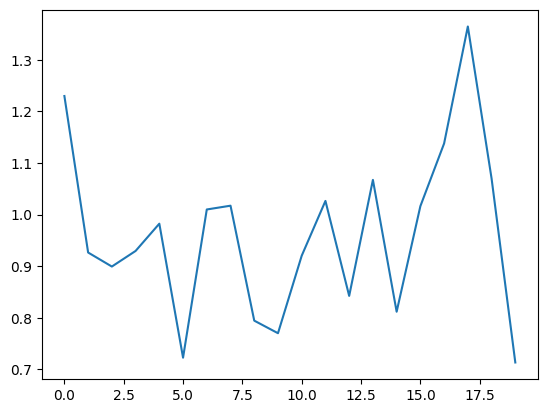

In [22]:
import matplotlib.pyplot as plt

plt.clf()
x = range(0, len(tot_speed_up))
y = tot_speed_up
plt.plot(x, y) 

# 1.2 **The problem**
From the error study we have seen that our code give a good approximation of the exact solution. We now implement the code in order to find an approximation of the unknown solution of the nonlinear elliptic problem with the forcing term equal to 
$$
g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
$$

In [23]:
# Right hand side g given from the problem
def RHS_g(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_g = 100.0 * np.sin(2 * np.pi * matPoints[0,:]) * np.cos(2 * np.pi * matPoints[1,:])
	return values_g.ctypes.data

## **POD**
### Snapshot matrix 

In [24]:

################################ SNAPSHOT MATRIX ##############################
snapshot_matrix = []

tol = 1. - 1e-7
N_max = 10
num_iteration = 1 
# variable storing the index i i-th sample parameters considered
i = 1

for mu in training_set:
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm] = compute_FOM(mu, lib, problemData, compute_time=False, exact_solution=False)
    snapshot_matrix.append(np.copy(u_k))
    i = i+1

snapshot_matrix = np.array(snapshot_matrix)


Params: [0.47531980423231657, 0.7482920440979423]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 9.7118905962217845e-03 2 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.5660748933162962e-04 3 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 2.5096365949246665e-06 4 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 3.9675694412972216e-08 5 20
Params: [0.1001029373356104, 0.3720993153686558]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 4.9025083246824770e-03 2 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 4.6356816321537576e-05 3 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 6.2040660089537697e-07 4 20
Params: [

In [25]:
print(f'Snapshot matrix dimension (M x N_sigma): {snapshot_matrix.shape}')

Snapshot matrix dimension (M x N_sigma): (300, 57)


### Covariance matrix

In [26]:
# Inner_product is necessary sicne we are dealing with the energy norm and not L2 norm. 
# As a consequence, the obtained basis won't be the best possible but an approximation of them. (Theorem hypothesis of best approximation is satisfied in L2)
C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) ## metti inner product

# VM, L, VMt = np.linalg.svd((C))

# compute eigenvalues and eigenvectors
L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []


#### check

for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.)
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print("The reduced dimension is", N)
print(relative_retained_energy)

The reduced dimension is 2
[0.99999179 0.99999993 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.    

### Basis matrix

In [27]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  basis = np.transpose(snapshot_matrix) @ eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis)
  basis /= norm
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))
print(f'Basis functions dimension: {basis_functions.shape}')

Basis functions dimension: (57, 2)


### Standard ROMs
If we want to perform standard ROMs we still need to implement the Newton algorithm and assemble the system.

#### New parameters

In [28]:
mu = [0.8, 0.4]

In [29]:
#[u_k, u_strong, sol_norm, res_norm] = compute_ROM(mu, lib, problemData, exact_solution=True)
[u_k, u_strong, sol_norm, res_norm, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=False)
print(f'Computation of ROM time:')
print(sum(time_ROM)+sum(time_assembling_ROM))

Params: [0.8, 0.4]
REDUCED SOLUTION
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 2.7850935052703080e-03 2 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.3423587180663272e-05 3 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.0911518153133265e-07 4 20
Computation of ROM time:
0.16271328926086426


### Plot Solution

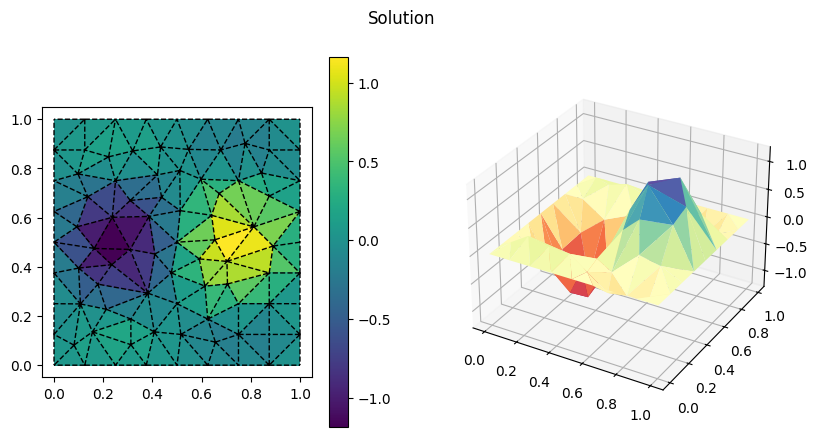

In [30]:
#Visualizzazione della soluzione e calcolo dell'errore FONDAMENTALI NEL PROGETTO !!!
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)

#PLotSolution implements in Pyton the two plot of 2D and 3D plots of the solution. IT's better to export the solution in order to visulize the solution in other applications, as ParaView
#ExportSolution give us a file .inp which is the file format of the UCD structur file. It's limitated to specific type of geometrical elemntsù: tringle hexahedron, thetraedron, pyramidon, line, points.
# Filter "Warp by scalar" in ParaView let choos one of the scalar associated to the solution... to 3D visualization
gedim.ExportSolution(Test_exactSolution, u_k, u_strong, lib)

#Nella costruzione delle funzioni non ci interessava sapere chi fossero i nodi di quadratura per la costruzione delle matrici. In questo caso invece, dovendo valutare l'errore in tutte
#le celle dobbiamo conoscere i nodi di quadratura in tutto il dominio e li salviamo nella matrice globale quadraturePoints
#Inoltre per ogni nodo di quadratura dobbiamo conoscere il peso per cui dobbiamo moltiplicare, altrimenti l'approssimazione dell'integrale non è corretta. 
#La sommma dei pesi è 1 poichè approssimo l'integrale della funzione unitaria che fornisce la misura del nostro dominio
[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)

#If the order of FE is 2 the PlotSoution does not use the info on the middle points of the FE but just that on the vertices
#In order to taking account also of the dofs that are not equal to the vertices we use ExtractSolutionOnPoints.
#We have a collection of points and in each point we have a value of the solution: we have the galerkin numerical solution evaluated in each qadrature formula. 
#We don't have the solution on the cells.
#In order to have the solution on cells we have to add a filter to the numeric solution that is associated to each point of the mesh, not to the cell. We need to change cell
#array to point array: using cellDataPointData.
#Then, we have to generate a mesh: we use the Delauneay 2D from the filter on the solution on points. We obtain a mesh conformed to our points.
#The borders are missing because the quadrature formula is implemented INSIDE the cells. We add the warpByScalar filter and we see the expected better approximation of the exact solution
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) 


#If we have a network, notice that sol is an array with shape 864, and for each point we have the evaluation of the solution on each point. In Galerkin it is correct, but not in NN
#In the latter case we have to evaluate the network in quadrature points adding the line 
#nn(QuadraturePoints)
#before the export.

### Speed-up

In [31]:
import time

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(10, P.shape[0]))
speed_up = []

for mu in testing_set:
    [u_k, u_strong, sol_norm_L2, sol_norm_H1, res_norm, time_FOM, time_assembling_FOM] = compute_FOM(mu, lib, problemData, compute_time=True, exact_solution=False)
    [u_k, u_strong, sol_norm, res_norm, time_ROM, time_assembling_ROM] = compute_ROM(mu, lib, problemData, compute_time=True, exact_solution=False)

    speed_up.append(sum(time_FOM+time_assembling_FOM)/sum(time_ROM+time_assembling_ROM))

    error_vector = u_k - u_k_proj
    error_norm_squared_comp = np.transpose(error_vector) @ inner_product @ error_vector
    absolute_error = np.sqrt(np.abs(error_norm_squared_comp))
    abs_err.append(absolute_error)

    full_solution_norm_squared_component = np.transpose(u_k) @  inner_product @ u_k
    relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
    rel_err.append(relative_error)


Params: [0.17209327942544436, 0.9141679026426186]
HIGH FIDELITY SOLUTION
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.8671939075297517e-02 2 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 8.8889014967091285e-04 3 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 4.3144874316834066e-05 4 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 2.0517069269699342e-06 5 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 9.6782514000351093e-08 6 20
Params: [0.17209327942544436, 0.9141679026426186]
REDUCED SOLUTION
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 1.0000000000000000e+00 1 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 2.0567614817882822e-02 2 20
dofs h residual iteration max_iteration
57 2.0647876100132428e-01 9.3550628959889381e-04 3 20
dofs h residua

In [32]:
print(f'Average relative error: {np.mean(rel_err)}')
print(f'Average absolute error: {np.mean(abs_err)}')
print(f'Average speed-up: {np.mean(speed_up)}')

Average relative error: 1.1443453894991353
Average absolute error: 4.903335717873565
Average speed-up: 1.1071731669138773


In [33]:
# print(speed_up)

## 2. Solve the problem with a parametric PINN
# 2.1 **Test**

 In order to implement an error study of the code we will implement, firstly we solve the Nonlinear Elliptic problem by means of PINN method over a Finite Element full order model by choosing the exact solution $u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1-x_0)(1-x_1)$ and computing the respective right hand side define as

 $$
 g_{ex}(\mathbf{x};\mathbf{\mu}) = -\Delta u_{ex}(\mathbf{x};\mathbf{\mu})+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})}-1\right) = 32 (x_0(1-x_0)+x_1(1-x_1))+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
 $$
 
 Then we will apply our code to the problem introduced above.

In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable

#### The Network

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(4,7) #input layer: n=4 inputs = x_0, x_1, mu_0, mu_1
        self.hidden_layer1 = nn.Linear(7,7) # we start with a single hidden layer: N_l = n + m + 2 = 7 from the UAT-2
        self.hidden_layer2 = nn.Linear(7,7)
        self.hidden_layer3 = nn.Linear(7,7)
        self.hidden_layer4 = nn.Linear(7,7)
        self.hidden_layer5 = nn.Linear(7,7)
        self.output_layer = nn.Linear(7,1) # output layer: m=1: u is scalar

    def forward(self, x_0, x_1, mu_0, mu_1): #we put sigmoid over all the layers
        input = torch.cat([x_0, x_1, mu_0, mu_1],axis=1) # combines the column array
        layer1_out = torch.sigmoid(self.input_layer(input)) #
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        layer6_out = torch.sigmoid(self.hidden_layer5(layer5_out))
        output = self.output_layer(layer5_out) #in the end only the output layer
        return output

In [23]:
### (2) Model
seed = 0
torch.manual_seed(seed)
net = Net()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

#### The Residual

In [16]:
## PDE as loss function.
def R(x_0, x_1, mu_0, mu_1, net, exact = False):
    
    u = net(x_0, x_1, mu_0 , mu_1) # previsione valore con rete
    u_x0 = torch.autograd.grad(u.sum(), x_0, create_graph=True)[0] #derivative of u over x_0
    u_xx0 = torch.autograd.grad(u_x0.sum(), x_0, create_graph=True)[0] #second derivative of u over x_0

    u_x1 = torch.autograd.grad(u.sum(), x_1, create_graph=True)[0] #derivative of u over x_1
    u_xx1 = torch.autograd.grad(u_x1.sum(), x_1, create_graph=True)[0] #second derivative of u over x_1

    u_xx = u_xx0 + u_xx1

    if exact:
        g = torch.Tensor(32.0 * (x_1.detach().numpy() * (1.0 - x_1.detach().numpy()) + x_0.detach().numpy() * (1.0 - x_0.detach().numpy())) + \
                      	 +  mu_0.detach().numpy() / mu_1.detach().numpy() * (np.exp(mu_1.detach().numpy() * 16 * x_0.detach().numpy() * x_1.detach().numpy() * \
                         (1.0 - x_0.detach().numpy()) * (1.0 - x_1.detach().numpy()))-1))
    else:
        g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0.detach().numpy()) * np.cos(2 * np.pi * x_1.detach().numpy()))
    
    f_nolin = mu_0 / mu_1 * (torch.exp(mu_1 * u)-1)
    
    pde = - u_xx + f_nolin - g

    # pde = - u_xx + f_nolin - g
    
    return pde

#### Data from BCs

In [17]:
# TRAINING SET
size = 200

x0_bc = np.random.uniform(low=0.0, high=1.0, size=(size,1))
x1_bc = np.random.uniform(low=0.0, high=1.0, size=(size,1))

all_zeros = np.zeros((size,1))
all_ones = np.ones((size,1))

l_x0 = np.concatenate([x0_bc, all_ones, x0_bc, all_zeros], axis=0)
l_x1 = np.concatenate([all_zeros, x1_bc, all_ones, x1_bc], axis=0)

#l_1 = np.concatenate([x0_bc, all_zeros], axis=1) # edge [0,1]x{0}
#l_2 = np.concatenate([all_ones, x1_bc], axis=1) # edge {1}x[0,1]
#l_3 = np.concatenate([x0_bc, all_ones], axis=1) # edge [0,1]x{1}
#l_4 =np.concatenate([all_zeros, x1_bc], axis=1) # edge {0}x[0,1]

u_bc = np.zeros((size*4,1))

# training set relative to mu
np.random.seed(42)
training_set_mu0 = np.random.uniform(low=0.1, high=1.0, size=(size*4,1))
training_set_mu1 = np.random.uniform(low=0.1, high=1.0, size=(size*4,1))



Hyper-parameters tuning

In [21]:
# Numero hidden layers variare
# fare grafico training loss per trovare numero di epochs

In [25]:
def Initialize_model(seed): 
    torch.manual_seed(seed)
    net = Net()
    mse_cost_function = torch.nn.MSELoss() # Mean squared error
    optimizer = torch.optim.Adam(net.parameters())
    return net, mse_cost_function, optimizer

### Training / Fitting

In [32]:
iterations = 20000

def training(iterations, net, mse_cost_function, optimizer, l_x0, l_x1, training_set_mu0, training_set_mu1, u_bc):
    loss_track = []
    for epoch in range(iterations):
        optimizer.zero_grad() # to make the gradients zero
    
        # Loss based on boundary conditions
        pt_x0_bc = Variable(torch.from_numpy(l_x0).float(), requires_grad=False)
        pt_x1_bc = Variable(torch.from_numpy(l_x1).float(), requires_grad=False)
    
        mu_0_tensor = Variable(torch.from_numpy(training_set_mu0).float(), requires_grad=False)
        mu_1_tensor = Variable(torch.from_numpy(training_set_mu1).float(), requires_grad=False)
    
        # mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(pt_x0_bc.size(0), 1)
        # mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(pt_x1_bc.size(0), 1)
        
        # condizione di dirichlet omogenea
        pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
        
        net_bc_out = net(pt_x0_bc, pt_x1_bc, mu_0_tensor, mu_1_tensor) # output of u(x)
        mse_u = mse_cost_function(net_bc_out, pt_u_bc)
        
        # Loss based on PDE
        x0_collocation = np.random.uniform(low=0.0, high=1.0, size=(size*4,1))
        x1_collocation = np.random.uniform(low=0.0, high=1.0, size=(size*4,1))
        all_zeros = np.zeros((size*4,1)) # 500 points over a line
        
        
        pt_x0_collocation = Variable(torch.from_numpy(x0_collocation).float(), requires_grad=True)
        pt_x1_collocation = Variable(torch.from_numpy(x1_collocation).float(), requires_grad=True)
    
        
        pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False) #label map for each of the 500 points, because we want a zero residual
        f_out = R(pt_x0_collocation, pt_x1_collocation, mu_0_tensor, mu_1_tensor, net) # output of R(x)
        mse_f = mse_cost_function(f_out, pt_all_zeros)
        
        # Combining the loss functions
        loss = mse_f + coeff * mse_u
        
        
        loss.backward() 
        optimizer.step()
    
        with torch.autograd.no_grad():
            print(epoch,"Loss:",loss.item())
            if epoch % 10 == 0:
                loss_track.append(loss.item())
    return net, loss_track
        

In [29]:
coeff = 0.01
[net, training_loss] = training(iterations, net, mse_cost_function, optimizer, l_x0, l_x1, training_set_mu0, training_set_mu1, u_bc)

0 Loss: 2452.667724609375
1 Loss: 2578.6962890625
2 Loss: 2509.224365234375
3 Loss: 2396.897705078125
4 Loss: 2570.82177734375
5 Loss: 2334.46337890625
6 Loss: 2470.991455078125
7 Loss: 2596.281494140625
8 Loss: 2491.626220703125
9 Loss: 2619.096435546875
10 Loss: 2469.333984375
11 Loss: 2502.8486328125
12 Loss: 2623.89990234375
13 Loss: 2563.2978515625
14 Loss: 2437.39599609375
15 Loss: 2351.024169921875
16 Loss: 2454.10400390625
17 Loss: 2588.1708984375
18 Loss: 2457.27880859375
19 Loss: 2459.85791015625
20 Loss: 2485.717041015625
21 Loss: 2503.877197265625
22 Loss: 2676.307861328125
23 Loss: 2534.9423828125
24 Loss: 2489.67431640625
25 Loss: 2501.747802734375
26 Loss: 2543.763427734375
27 Loss: 2490.9248046875
28 Loss: 2362.385986328125
29 Loss: 2391.345947265625
30 Loss: 2484.9150390625
31 Loss: 2651.4326171875
32 Loss: 2559.9443359375
33 Loss: 2632.051025390625
34 Loss: 2510.32470703125
35 Loss: 2464.01904296875
36 Loss: 2640.0517578125
37 Loss: 2507.5126953125
38 Loss: 2487.02050

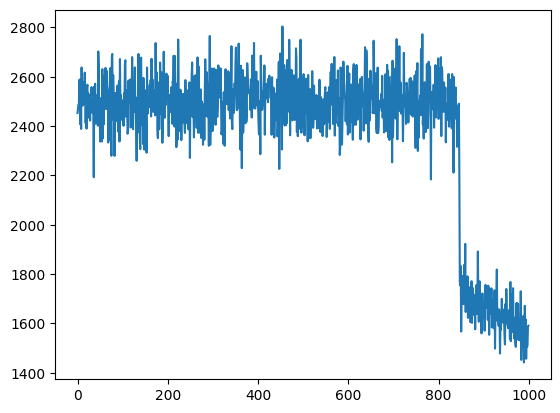

In [31]:
import matplotlib.pyplot as plt

plt.clf()
x = range(0, len(training_loss))
y = training_loss
plt.plot(x, y) 

In [39]:
meshSize = 0.01 #We choose a meshsize = maximum area required in our domain discretization
order = 1 #Order of finite element

#all the boundary condition are homogenous dirichlet boundary condition so we use just one marker for the border equal to 1
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize } 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

# BoundaryConditionsType=2 means Dirichlet conditions
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] } 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

x0 = dofs[0].reshape(-1,1)
x1 = dofs[1].reshape(-1,1)
# transform to tensor
x_0_tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True)
x_1_tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu_0 = 0.8
mu_1 = 0.4
mu_0_tensor = torch.tensor(mu_0, dtype=torch.float32).expand(x_0_tensor.size(0), 1)
mu_1_tensor = torch.tensor(mu_1, dtype=torch.float32).expand(x_0_tensor.size(0), 1)
x_0_tensor.shape
x_1_tensor.shape[0]

57

In [46]:
def predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net):
    
    all_zeros = np.zeros((x_1_tensor.shape[0],1))
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False) #label map for each of the 500 points, because we want a zero residual
    u_pred = net(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor)
    # mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    u_x0 = torch.autograd.grad(u_pred.sum(), x_0_tensor, create_graph=True)[0] #derivative of u over x_0
    u_xx0 = torch.autograd.grad(u_x0.sum(), x_0_tensor, create_graph=True)[0]
    
    
    u_x1 = torch.autograd.grad(u_pred.sum(), x_1_tensor, create_graph=True)[0] #derivative of u over x_1
    u_xx1 = torch.autograd.grad(u_x1.sum(), x_1_tensor, create_graph=True)[0] #second derivative of u over x_1
    
    u_xx = u_xx0 + u_xx1
    
    #g_ex = torch.Tensor(32.0 * (x_1_tensor.detach().numpy() * (1.0 - x_1_tensor.detach().numpy()) + x_0_tensor.detach().numpy() * (1.0 - x_0_tensor.detach().numpy())) + \
                         #+  mu_0_tensor.detach().numpy() / mu_1_tensor.detach().numpy() * (np.exp(mu_1_tensor.detach().numpy() * 16 * x_0_tensor.detach().numpy() * x_1_tensor.detach().numpy() * \
                        #(1.0 - x_0_tensor.detach().numpy()) * (1.0 - x_1_tensor.detach().numpy()))-1))
    
    g = torch.Tensor(100.0 * np.sin(2 * np.pi * x_0_tensor.detach().numpy()) * np.cos(2 * np.pi * x_1_tensor.detach().numpy()))
    
    f_nolin = mu_0_tensor / mu_1_tensor * (torch.exp(mu_1_tensor * u_pred)-1)
    
    pde = - u_xx + f_nolin - g

    mse_f = mse_cost_function(pde, pt_all_zeros)
    

# u_pred = net(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor)

    return u_pred, mse_f
    

In [53]:
[predPoints, mse] = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net)
predPoints.shape
mse

tensor(690.0591, grad_fn=<MseLossBackward0>)

In [42]:
u_x0 = torch.autograd.grad(predPoints.sum(), x_0_tensor, create_graph=True)[0]

In [28]:
mu_0_tensor.shape

torch.Size([57, 1])

In [54]:
#predPoints = predict(x_0_tensor, x_1_tensor, mu_0_tensor, mu_1_tensor, net)
predPoints = predPoints.data.cpu().numpy()
predPoints = predPoints.reshape(-1)
u_strong = np.zeros(problemData['NumberStrongs'], order='F')
u_strong.shape
predPoints.shape

(57,)

In [55]:
u_k = np.zeros(problemData['NumberDOFs'], order='F') 
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [66]:
u_k.shape

(57,)

### Plot

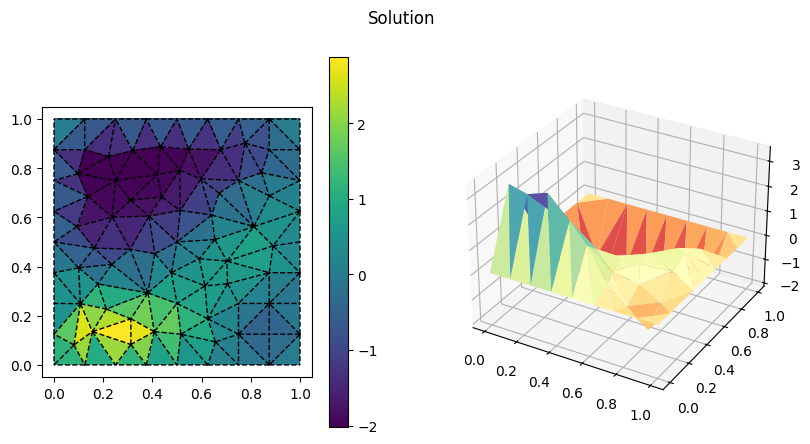

ArgumentError: argument 1: TypeError: array must have data type float64

In [56]:
#Visualizzazione della soluzione e calcolo dell'errore FONDAMENTALI NEL PROGETTO !!!
gedim.PlotSolution(mesh, dofs, strongs, predPoints, u_strong)

#PLotSolution implements in Pyton the two plot of 2D and 3D plots of the solution. IT's better to export the solution in order to visulize the solution in other applications, as ParaView
#ExportSolution give us a file .inp which is the file format of the UCD structur file. It's limitated to specific type of geometrical elemntsù: tringle hexahedron, thetraedron, pyramidon, line, points.
# Filter "Warp by scalar" in ParaView let choos one of the scalar associated to the solution... to 3D visualization

# gedim.ExportSolution(Test_exactSolution, predPoints, u_strong, lib)

#Nella costruzione delle funzioni non ci interessava sapere chi fossero i nodi di quadratura per la costruzione delle matrici. In questo caso invece, dovendo valutare l'errore in tutte
#le celle dobbiamo conoscere i nodi di quadratura in tutto il dominio e li salviamo nella matrice globale quadraturePoints
#Inoltre per ogni nodo di quadratura dobbiamo conoscere il peso per cui dobbiamo moltiplicare, altrimenti l'approssimazione dell'integrale non è corretta. 
#La sommma dei pesi è 1 poichè approssimo l'integrale della funzione unitaria che fornisce la misura del nostro dominio

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(predPoints, u_strong, lib)

#If the order of FE is 2 the PlotSoution does not use the info on the middle points of the FE but just that on the vertices
#In order to taking account also of the dofs that are not equal to the vertices we use ExtractSolutionOnPoints.
#We have a collection of points and in each point we have a value of the solution: we have the galerkin numerical solution evaluated in each qadrature formula. 
#We don't have the solution on the cells.
#In order to have the solution on cells we have to add a filter to the numeric solution that is associated to each point of the mesh, not to the cell. We need to change cell
#array to point array: using cellDataPointData.
#Then, we have to generate a mesh: we use the Delauneay 2D from the filter on the solution on points. We obtain a mesh conformed to our points.
#The borders are missing because the quadrature formula is implemented INSIDE the cells. We add the warpByScalar filter and we see the expected better approximation of the exact solution
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) 


#If we have a network, notice that sol is an array with shape 864, and for each point we have the evaluation of the solution on each point. In Galerkin it is correct, but not in NN
#In the latter case we have to evaluate the network in quadrature points adding the line 
#nn(QuadraturePoints)
#before the export.

In [ ]:
#Per il plot: crare una griglia di punti corrispondenti ai dof della mesh utilizzata per i POD così da poter sfruttare le funzioni
# [numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
# gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib) 
# per la rappresentazione della funzione in Paraview

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

x=np.random.uniform(low=0.0, high=2.0, size=(100,1))

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
pt_u = net(pt_x)
u=pt_u.data.cpu().numpy()
plt.scatter(x, u)
plt.show()